## **0. Download dataset**
**Note:** If you can't download using gdown due to limited number of downloads, please download it manually and upload it to your drive, then copy it from the drive to colab.
```python
from google.colab import drive

drive.mount('/content/drive')
!cp /path/to/dataset/on/your/drive .
```

In [1]:
# https://drive.google.com/file/d/1q4ovo8lBydocD5ecmq3I2i10lhvgAee9/view?usp=sharing
!gdown --id 1q4ovo8lBydocD5ecmq3I2i10lhvgAee9 --quiet
# !unzip twitter_sentiment_analysis_2cls_dataset.zip
!mv sentiment_analysis.csv ../data/

/home/banhmuy/miniconda3/envs/ds_env/lib/python3.11/site-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(


## **1. Import libraries**

In [2]:
!pip install -q nltk

In [31]:
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from nltk.tokenize import TweetTokenizer
from collections import defaultdict

## **2. Read dataset**

In [32]:
dataset_path = '../data/sentiment_analysis.csv'
df = pd.read_csv(
    dataset_path,
    index_col='id'
)
df.head(5)

,label,tweet
id,,
1,0,#fingerprint #Pregnancy Test https://goo.gl/h1...
2,0,Finally a transparant silicon case ^^ Thanks t...
3,0,We love this! Would you go? #talk #makememorie...
4,0,I'm wired I know I'm George I was made that wa...
5,1,What amazing service! Apple won't even talk to...


In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7920 entries, 1 to 7920
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   7920 non-null   int64 
 1   tweet   7920 non-null   object
dtypes: int64(1), object(1)
memory usage: 185.6+ KB


In [34]:
df.describe()

,label
count,7920.000000
mean,0.255808
std,0.436342
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


## **3. Preprocessing data**



In [35]:
def text_normalize(text):
    # Convert to lowercase
    text = text.lower()

    # Retweet old acronym "RT" removal
    text = re.sub(r'^RT[\s]+', '', text)

    # Hyperlinks removal
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text)

    # Remove punctuation and special characters using regex
    text = re.sub(r"[^\w\s]", "", text)

    # Normalize whitespace (replace multiple spaces with a single space)
    text = re.sub(r"\s+", " ", text)

    # Strip leading/trailing whitespace and split into tokens
    tokenizer = TweetTokenizer(
        preserve_case=False,
        strip_handles=True,
        reduce_len=True
    )
    text_tokens = tokenizer.tokenize(text)

    return text_tokens

In [36]:
text = """We love this! Would you go?
#talk #makememories #unplug
 #relax #iphone #smartphone #wifi #connect...
http://fb.me/6N3LsUpCu
"""
text = text_normalize(text)
text

['we',
 'love',
 'this',
 'would',
 'you',
 'go',
 'talk',
 'makememories',
 'unplug',
 'relax',
 'iphone',
 'smartphone',
 'wifi',
 'connect']

In [37]:
def get_freqs(df):
    freqs = defaultdict(lambda: 0)
    for idx, row in df.iterrows():
        tweet = row['tweet']
        label = row['label']

        tokens = text_normalize(tweet)
        for token in tokens:
            pair = (token, label)
            freqs[pair] += 1

    return freqs

freqs = get_freqs(df)

In [39]:
def get_feature(text, freqs):
    tokens = text_normalize(text)

    X = np.zeros(3)
    X[0] = 1

    for token in tokens:
        X[1] += freqs[(token, 0)]
        X[2] += freqs[(token, 1)]

    return X

In [40]:
X = []
y = []

for idx, row in df.iterrows():
    tweet = row['tweet']
    label = row['label']

    X_i = get_feature(tweet, freqs)
    X.append(X_i)
    y.append(label)

X = np.array(X)
y = np.array(y)

print(f'X shape: {X.shape}')
print(f'y shape: {y.shape}')

X shape: (7920, 3)
y shape: (7920,)


## **4. Create train, val, test set**

In [41]:
val_size = 0.2
test_size = 0.125
RANDOM_STATE = 42
is_shuffle = True

X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=val_size,
    random_state=RANDOM_STATE,
    shuffle=is_shuffle
)

X_train, X_test, y_train, y_test = train_test_split(
    X_train, y_train,
    test_size=test_size,
    random_state=RANDOM_STATE,
    shuffle=is_shuffle
)

print(f'Number of training samples: {X_train.shape[0]}')
print(f'Number of val samples: {X_val.shape[0]}')
print(f'Number of test samples: {X_test.shape[0]}')

Number of training samples: 5544
Number of val samples: 1584
Number of test samples: 792


## **5. Normalization**

In [42]:
normalizer = StandardScaler()
X_train[:, 1:] = normalizer.fit_transform(X_train[:, 1:])
X_val[:, 1:] = normalizer.transform(X_val[:, 1:])
X_test[:, 1:] = normalizer.transform(X_test[:, 1:])

print('X_train', X_train)
print('X_val', X_val)
print('X_test', X_test)

X_train [[ 1.          0.82200123  1.83493432]
 [ 1.          1.61791816 -0.20987073]
 [ 1.          0.77472602  0.16150633]
 ...
 [ 1.          0.56798519  0.4064466 ]
 [ 1.         -0.66540382 -0.0973172 ]
 [ 1.         -1.17449431 -1.14649458]]
X_val [[ 1.         -0.20111894 -0.90403345]
 [ 1.         -0.94305747 -0.58174362]
 [ 1.         -0.5288702  -1.04931179]
 ...
 [ 1.          0.28256994  0.51057101]
 [ 1.         -0.30907576  0.52445427]
 [ 1.         -0.20746934 -0.47464423]]
X_test [[ 1.          1.48914614  0.27505152]
 [ 1.          0.11851791 -0.28622863]
 [ 1.         -0.94023507 -0.65512653]
 ...
 [ 1.          1.60945096 -0.21036656]
 [ 1.         -0.18453734 -0.73346776]
 [ 1.          1.61791816  2.04566229]]


## **6. Define essential functions**

### **6.1. Sigmoid function**

In [43]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

### **6.2. Binary Cross-entropy loss function**

In [44]:
def compute_loss_bce(y_hat, y):
    y_hat = np.clip(y_hat, 1e-7, 1 - 1e-7)
    return -(y * np.log(y_hat) + (1 - y) * np.log(1 - y_hat)).mean()

### **6.3. Hypothesis function**

In [45]:
def predict(X, theta):
    dot_product = np.dot(X, theta)
    y_hat = sigmoid(dot_product)

    return y_hat

### **6.4. Gradient function**

In [46]:
def compute_gradient(x, y_hat, y):
    return np.dot(
        x.T, (y_hat - y)
    ) / y.size

### **6.5. Update weights function**

In [47]:
def update_gradient(theta, lr, gradient):
    return theta - lr * gradient

### **6.6. Accuracy function**

In [48]:
def compute_accuracy(X, y, theta):
    y_preds = predict(X, theta).round()
    acc = (y_preds == y).mean()
    return acc

## **7. Training**

In [49]:
# Hyperparameters
lr = 0.1
epochs = 500
batch_size = 128
np.random.seed(RANDOM_STATE)
theta = np.random.uniform(size=X.shape[1])

In [50]:
train_losses = []
train_accs = []
val_losses = []
val_accs = []

for epoch in range(epochs):
    train_batch_losses = []
    train_batch_accs = []
    val_batch_losses = []
    val_batch_accs = []
    for i in range(0, X_train.shape[0], batch_size):
        xi = X_train[i: i + batch_size]
        yi = y_train[i: i + batch_size]

        y_hat = predict(xi, theta)

        loss = compute_loss_bce(y_hat, yi)
        train_batch_losses.append(loss)

        gradient = compute_gradient(xi, y_hat, yi)
        theta = update_gradient(theta, lr, gradient)

        # pre-test for train
        acc = compute_accuracy(X_val, y_val, theta)
        train_batch_accs.append(acc)

        # validate
        y_val_preds = predict(X_val, theta).round()
        val_loss = compute_loss_bce(y_val_preds, y_val)
        val_batch_losses.append(val_loss)
        val_acc  = compute_accuracy(X_val, y_val, theta)
        val_batch_accs.append(val_acc)

    train_loss = sum(train_batch_losses) / len(train_batch_losses)
    train_acc = sum(train_batch_accs) / len(train_batch_accs)
    val_loss = sum(val_batch_losses) / len(val_batch_losses)
    val_acc = sum(val_batch_accs) / len(val_batch_accs)

    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    val_losses.append(val_loss)
    print(f"[EPOCH {epoch + 1}] \t train_loss: {train_loss:.4f}, \t train_acc: {train_acc:.4f}, \
           \t val_loss: {val_loss:.4f}, \t val_acc: {val_acc:.4f}")


[EPOCH 1] 	 train_loss: 0.6223, 	 train_acc: 0.6857,            	 val_loss: 5.0654, 	 val_acc: 0.6857
[EPOCH 2] 	 train_loss: 0.4810, 	 train_acc: 0.7710,            	 val_loss: 3.6905, 	 val_acc: 0.7710
[EPOCH 3] 	 train_loss: 0.4437, 	 train_acc: 0.7807,            	 val_loss: 3.5353, 	 val_acc: 0.7807
[EPOCH 4] 	 train_loss: 0.4264, 	 train_acc: 0.7831,            	 val_loss: 3.4958, 	 val_acc: 0.7831
[EPOCH 5] 	 train_loss: 0.4152, 	 train_acc: 0.7881,            	 val_loss: 3.4158, 	 val_acc: 0.7881
[EPOCH 6] 	 train_loss: 0.4070, 	 train_acc: 0.7891,            	 val_loss: 3.4000, 	 val_acc: 0.7891
[EPOCH 7] 	 train_loss: 0.4008, 	 train_acc: 0.7923,            	 val_loss: 3.3485, 	 val_acc: 0.7923
[EPOCH 8] 	 train_loss: 0.3960, 	 train_acc: 0.7988,            	 val_loss: 3.2432, 	 val_acc: 0.7988
[EPOCH 9] 	 train_loss: 0.3921, 	 train_acc: 0.8014,            	 val_loss: 3.2009, 	 val_acc: 0.8014
[EPOCH 10] 	 train_loss: 0.3890, 	 train_acc: 0.8044,            	 val_loss: 3.153

Text(0.5, 1.0, 'Validate Accuracy over Epochs')

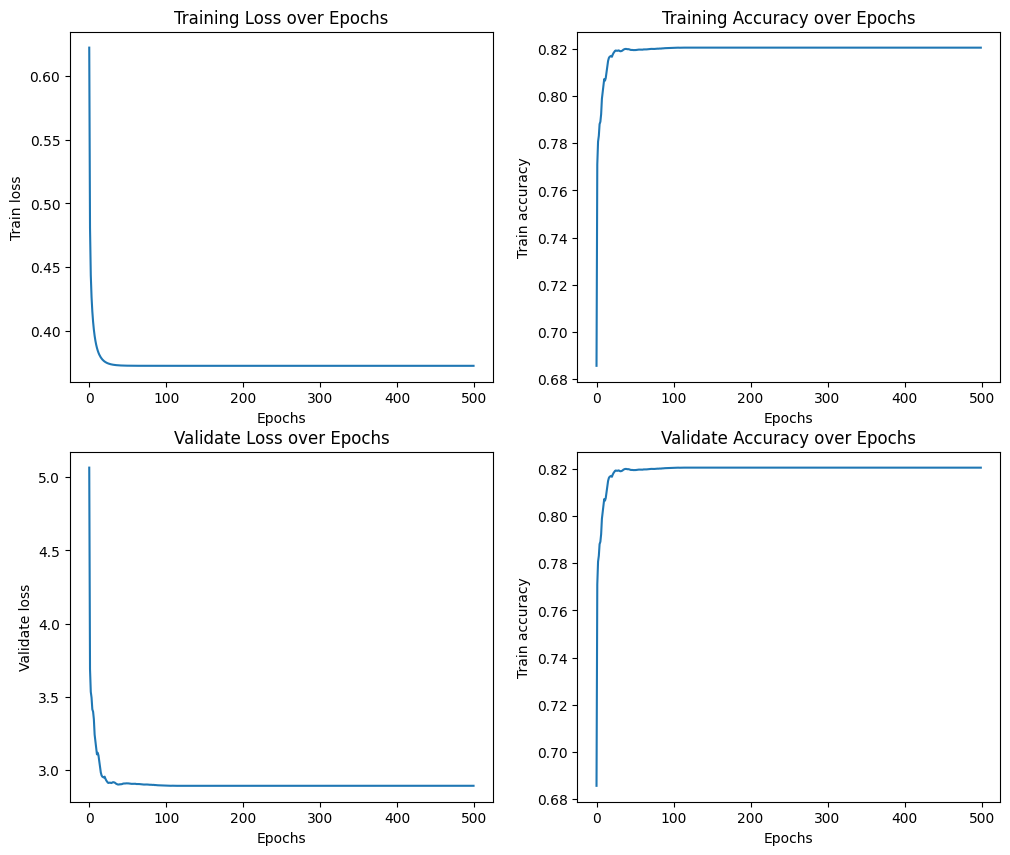

In [51]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
ax[0, 0].plot(train_losses, label='Train loss')
ax[0, 0].set(xlabel='Epochs', ylabel='Train loss')
ax[0, 0].set_title("Training Loss over Epochs")

ax[0, 1].plot(train_accs, label='Train accuracy')
ax[0, 1].set(xlabel='Epochs', ylabel='Train accuracy')
ax[0, 1].set_title("Training Accuracy over Epochs")

ax[1, 0].plot(val_losses, label='Validate losses')
ax[1, 0].set(xlabel='Epochs', ylabel='Validate loss')
ax[1, 0].set_title("Validate Loss over Epochs")

ax[1, 1].plot(val_accs, label='Validate accuracy')
ax[1, 1].set(xlabel='Epochs', ylabel='Train accuracy')
ax[1, 1].set_title("Validate Accuracy over Epochs")

## **8. Evaluation**

In [52]:
test_acc = compute_accuracy(X_test, y_test, theta)
print("Test Accuracy", test_acc)

Test Accuracy 0.8421717171717171


In [53]:
val_acc = compute_accuracy(X_val, y_val, theta)
print("Validate Accuracy", val_acc)

Validate Accuracy 0.8200757575757576
